In [1]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import faiss

import random
from collections import defaultdict
import heapq
import requests
import time
import zipfile
import shutil
from tqdm import tqdm
from typing import List, Callable, Tuple ,Set , Dict

from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine, cdist
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import tensorflow as tf


print(1)

1


# leveraging ANN to create multi_modal novel similarity search

In [2]:
methods_list={}

## The ANN FUNCTIONS
They are in self-contained callable form, meaning the indexing function returns the search function

### standard methods( hnsw and lsh)

In [3]:

# Type aliases for clarity
EmbeddingsList = List[List[np.ndarray]]  # List of lists of embeddings
SearchFunction = Callable[[List[np.ndarray]], Tuple[np.ndarray, np.ndarray]]

def hnsw_simple_concatenation_ann(data: EmbeddingsList) -> SearchFunction:
    """
    Simple concatenation method. Concatenates embeddings as-is.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    # Validate and process data
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    # Get dimensions and validate consistency
    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_dim = sum(dims)

    # Concatenate all data
    concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in data])
        for i in range(num_embedding_types)
    ]).astype('float32')

    # Create and train index
    index = faiss.IndexHNSWFlat(total_dim, 16)
    index.hnsw.efConstruction = 100
    index.hnsw.efSearch = 64
    index.add(concatenated_data)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        concatenated_query = np.hstack(query_embeddings).astype('float32').reshape((1,-1))
        distances, indices = index.search(concatenated_query, k)
        return distances, indices

    return search

methods_list["hnsw_simple_concatenation"] =hnsw_simple_concatenation_ann

In [4]:
def LSH_simple_concatenation_ann(data: EmbeddingsList, num_planes: int = 256) -> SearchFunction:
    """
    Normal LSH method. Applies LSH to concatenated embeddings.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        num_planes: Number of hyperplanes for LSH

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_dim = sum(dims)

    # Concatenate all data
    concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in data])
        for i in range(num_embedding_types)
    ]).astype('float32')

    # Create and train LSH index
    index = faiss.IndexLSH(total_dim, num_planes)
    index.train(concatenated_data)
    index.add(concatenated_data)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        concatenated_query = np.hstack(query_embeddings).astype('float32').reshape(1, -1)
        distances, indices = index.search(concatenated_query, k)
        return distances, indices

    return search


methods_list["LSH_simple_concatenation"] = LSH_simple_concatenation_ann


### standard ANN method separating indexing

In [5]:
EmbeddingsList = List[List[np.ndarray]]
SearchFunction = Callable[[List[np.ndarray]], Tuple[np.ndarray, np.ndarray]]

def multi_index_ann(data: EmbeddingsList) -> SearchFunction:
    """
    Creates separate indices for each embedding type and combines their results,
    calculating distances to all embeddings for each candidate.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)

    Returns:
        search_function: Function that takes query embeddings and returns combined results
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    entry_count = len(data)
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]

    # Create separate indices and store embeddings for each type
    indices = []
    embeddings_by_type = []

    for i in range(num_embedding_types):
        embeddings = np.vstack([entry[i] for entry in data]).astype('float32')
        embeddings_by_type.append(embeddings)

        index = faiss.IndexHNSWFlat(dims[i], 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(embeddings)
        indices.append(index)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Search in each index separately to get initial candidate set
        all_candidates: Set[int] = set()

        for i, (query, index) in enumerate(zip(query_embeddings, indices)):
            query_array = query.reshape(1, -1).astype('float32')
            _, indices_found = index.search(query_array, k)
            all_candidates.update(indices_found[0])

        # Calculate distances for all candidates across all embedding types
        candidate_scores = []

        for idx in all_candidates:
            total_distance = 0
            for i, query in enumerate(query_embeddings):
                # Reshape for broadcasting
                query_vector = query.reshape(1, -1)
                db_vector = embeddings_by_type[i][idx].reshape(1, -1)

                # Calculate L2 distance
                distance = np.linalg.norm(query_vector - db_vector)
                total_distance += distance

            candidate_scores.append((idx, total_distance))

        # Sort by total distance and get top k
        candidate_scores.sort(key=lambda x: x[1])
        final_indices = [idx for idx, _ in candidate_scores[:k]]
        final_distances = [dist for _, dist in candidate_scores[:k]]

        return (np.array(final_distances).reshape(1, -1),
                np.array(final_indices).reshape(1, -1))

    return search

methods_list["separate indexing"] =multi_index_ann

### custom ANN: split LSH ANN
lsh on each embedding separately simuntainsoly , by having the diving planes on only a single embedding indices dims

In [6]:
def split_lsh_ann(data: EmbeddingsList, num_planes: int = 256) -> SearchFunction:
    """
    Split LSH method. Applies LSH separately to each embedding type.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        num_planes: Total number of hyperplanes to be distributed among embedding types

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_dim = sum(dims)

    # Allocate planes proportionally to dimension sizes
    planes_per_type = [max(1, int(num_planes * dim / total_dim)) for dim in dims]

    # Adjust to ensure total equals num_planes
    while sum(planes_per_type) != num_planes:
        if sum(planes_per_type) < num_planes:
            idx = dims.index(max(dims))
            planes_per_type[idx] += 1
        else:
            idx = dims.index(min(dims))
            if planes_per_type[idx] > 1:
                planes_per_type[idx] -= 1

    # Create separate LSH indexes for each embedding type
    indexes = []
    for i, dim in enumerate(dims):
        index = faiss.IndexLSH(total_dim, planes_per_type[i])

        # Create masked training data
        masked_data = np.zeros((len(data), total_dim), dtype='float32')
        start_idx = sum(dims[:i])
        masked_data[:, start_idx:start_idx+dims[i]] = np.vstack([entry[i] for entry in data])

        index.train(masked_data)
        index.add(masked_data)
        indexes.append(index)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        concatenated_query = np.hstack(query_embeddings).astype('float32').reshape(1, -1)

        # Combine results from all indexes
        all_distances = []
        all_indices = []

        for i, index in enumerate(indexes):
            distances, indices = index.search(concatenated_query, k)
            all_distances.append(distances)
            all_indices.append(indices)

        # Merge and sort results
        merged_distances = np.hstack(all_distances)
        merged_indices = np.hstack(all_indices)

        # Sort by distance and take top k
        sorted_indices = np.argsort(merged_distances[0])[:k]
        final_distances = merged_distances[0][sorted_indices].reshape(1, -1)
        final_indices = merged_indices[0][sorted_indices].reshape(1, -1)

        return final_distances, final_indices

    return search

methods_list["Split LSH"] = split_lsh_ann

### standard ANN: normalise each embedding to have a co-sin similarly like search score

In [7]:
def just_norm_ann(data: EmbeddingsList) -> SearchFunction:

    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]

    # Normalize embeddings for consistent distance scaling
    normalized_data = []
    for i in range(num_embedding_types):
        embeddings = np.vstack([entry[i] for entry in data])
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)+0.001
        normalized_data.append(embeddings / norms)

    # Create separate indexes for each embedding type for efficient search
    indexes = []
    for i, emb in enumerate(normalized_data):
        index = faiss.IndexHNSWFlat(dims[i], 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(emb.astype('float32'))
        indexes.append(index)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Normalize query embeddings
        normalized_queries = []
        for query_emb in query_embeddings:
            norm = np.linalg.norm(query_emb)+0.001
            normalized_queries.append((query_emb / norm).astype('float32').reshape(1, -1))

        # Initial wide search in each embedding space
        expanded_k = min(k * 2, len(data))  # Search for more candidates initially
        all_candidates = set()
        per_type_results = []

        for i, (index, query) in enumerate(zip(indexes, normalized_queries)):
            distances, indices = index.search(query, expanded_k)
            all_candidates.update(indices[0])
            per_type_results.append((distances[0], indices[0]))

        # Calculate final scores for all candidates
        final_scores = []
        for idx in all_candidates:
            type_distances = []
            # Collect distances for this candidate across all embedding types
            for type_idx, (distances, indices) in enumerate(per_type_results):
                if idx in indices:
                    dist = distances[np.where(indices == idx)[0][0]]
                    type_distances.append(dist)
                else:
                    # If this candidate wasn't in top-k for this embedding type,
                    # use a default high distance
                    type_distances.append(1.0)

            # Calculate final score
            final_score = sum(type_distances) / len(type_distances)
            final_scores.append((final_score, idx))

        # Sort and get top k
        final_scores.sort()
        top_k = final_scores[:k]

        # Format results
        result_distances = np.array([[score for score, _ in top_k]])
        result_indices = np.array([[idx for _, idx in top_k]])

        return result_distances, result_indices

    return search

methods_list["just norm"] = just_norm_ann

### custom ANN: leaning weights for each embedding type

In [8]:
def wrapper_learn_class_weights(class_ids: List[int],stop_in =20) -> List[float]:
    def indexing_stage(data: EmbeddingsList) -> SearchFunction:
        """
        Learn the weights for each embedding type based on distances to the class center.
        The goal is to minimize the intra-class distance while maximizing the inter-class distance using
        learned weights.

        Args:
            data: List where each entry is a list of embeddings (one per embedding type).
            class_ids: List of class IDs corresponding to each entry in `data`.

        Returns:
            List of learned weights for each embedding type.
        """
        if not data or not class_ids:
            raise ValueError("Data and class_ids must not be empty.")
        if len(data) != len(class_ids):
            raise ValueError("Data and class_ids must have the same length.")

        num_samples = len(class_ids)
        num_embedding_types = len(data[0])

        # Initialize weights for each embedding type (starting with equal weights)
        weights = np.ones(num_embedding_types)

        # Compute class centers (mean) for each embedding type
        class_centers = {}
        # Store intra-class and extra-class distances for each embedding_type
        intra_class_distances = {}
        extra_class_distances = []
        extra_closer_intra = [0 for _ in range(num_embedding_types)]

        stop_in_i = stop_in
        for class_id in np.unique(class_ids):
            stop_in_i-=1
            if stop_in_i<0:
                break
            # Get the embeddings for each class
            class_indices = np.where(class_ids == class_id)[0]
            class_embeddings = [np.vstack([data[i][k] for i in class_indices]) for k in range(num_embedding_types)]

            # Calculate the center (mean) of each embedding type for this class
            class_centers[class_id] = [np.mean(embedding, axis=0) for embedding in class_embeddings]

            # Intra-class distances: distance to the center of the same class
            intra_dist = []
            for embedding ,center in zip(class_embeddings,class_centers[class_id]):

                dist = np.linalg.norm(embedding - center, axis=1)
                intra_dist.append(np.mean(dist))
            intra_class_distances[class_id.item()]=intra_dist

        # Loop through each class centers to sample and calculate distances
        for class_id,class_center in class_centers.items():
            not_class_indices = np.where(class_ids != class_id)[0]
            not_class_embeddings = [np.vstack([data[i][k] for i in not_class_indices]) for k in range(num_embedding_types)]
            extra_dist = []
            for i,(embedding ,center) in enumerate(zip(not_class_embeddings,class_center)):
                dist = np.linalg.norm(embedding - center, axis=1)
                extra_closer_intra[i]+= np.count_nonzero(dist < intra_class_distances[class_id][i] )
                extra_dist.append(np.mean(dist))
            extra_class_distances.append(extra_dist)

        # Calculate ratio (intra-class / inter-class distance)
        intra_class_distances_mean =[0 for _ in range(num_embedding_types)]
        for value in intra_class_distances.values():
            for i ,v in enumerate(value):
                intra_class_distances_mean[i] += v
        for i in range(len(intra_class_distances_mean)):
            intra_class_distances_mean[i] /= len(intra_class_distances)
        extra_class_distances_mean =[0 for _ in range(num_embedding_types)]
        for value in extra_class_distances:
            for i ,v in enumerate(value):
                extra_class_distances_mean[i] += v
        for i in range(len(extra_class_distances_mean)):
            extra_class_distances_mean[i] /= len(extra_class_distances)
        distance_ratios = [ext/intra for ext, intra in zip(extra_class_distances_mean, intra_class_distances_mean) ]

        # Use this ratio to adjust weights
        for i in range(num_embedding_types):
            # Weight will be proportional to the ratio of extra-class to intra-class distance
            if distance_ratios[i] < 1:
                weights[i] = 0
            else: # add some weight if few close to center
                weights[i] = np.power(distance_ratios[i],2) + -extra_closer_intra[i]/len(data)  # We can tweak this scaling
        weights /= np.mean(weights)
        weights = weights.tolist()

        print("during the training process of learn_class , found the weights for each embedding are",  weights)

        dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]

        # Create separate indices and store embeddings for each type

        embeddings_by_type = []
        embeddings = np.hstack([np.vstack([entry[i]*w for entry in data])for i , w in enumerate(weights)])

        index = faiss.IndexHNSWFlat(sum(dims), 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(embeddings)


        def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
            if len(query_embeddings) != num_embedding_types:
                raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

            # Calculate weighted average of query embeddings using learned weights
            weighted_query = np.hstack([query_embeddings[i]*w for i , w in enumerate(weights)]).reshape((1,-1))
            #print(index.search(weighted_query, k))
            distances, indices = index.search(weighted_query, k)
            return distances, indices


        return search
    return indexing_stage

def raise_error(x):
    raise "wrapper not started with class_ids"
methods_list["learn_class_weights"] = wrapper_learn_class_weights
methods_list["learn_class_weights"] = raise_error

### custom ANN: normalise and scal each embedding to bigger embedding similarly score

In [9]:
def normalized_scaled_ann(data: EmbeddingsList) -> SearchFunction:
    """
    Normalized and scaled concatenation method. Normalizes each embedding type
    and scales based on dimension size.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")


    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_dim = sum(dims)

    # Calculate scaling factors based on dimensions
    max_dim = max(dims)
    scaling_factors = [np.sqrt(max_dim / dim) for dim in dims]

    # Normalize and scale each embedding type, then concatenate
    #do Z-score normalization.
    # Find the maximum length of the embeddings in each column
    numberOfEmbeddings =len(data[0])
    max_lengths = [len(data[0][i]) for i in range(numberOfEmbeddings)]

    # Initialize lists to store sums and counts for each column
    sums = [np.zeros(mlengths) for mlengths in max_lengths]
    counts = len(data)

    # First pass: Calculate sums and counts for each index of embeddings in each column
    for row in data:
        for i in range(numberOfEmbeddings):
            sums[i]+=row[i]


    # Calculate means for each index of embeddings in each column
    means = [su /counts for su in sums]

    # Initialize lists to store squared differences for each column
    squared_diffs = [np.zeros(mlengths) for mlengths in max_lengths]

    # Second pass: Calculate squared differences from the mean for each index of embeddings in each column
    for row in data:
        for i in range(numberOfEmbeddings):
            squared_diffs[i]+= np.power(row[i]- means[i],2)

    # Calculate standard deviations for each index of embeddings in each column
    stds = [np.sqrt(squared_diff / counts) for squared_diff in squared_diffs]

    # to avoid division by zero
    for std in stds:
        std+= (std ==0 ) # mask is 1 where std == 0
    # Normalize the data
    normalized_data = []
    for row in data:
        normalized_row = []
        for mean ,std,ro in zip(means ,stds,row ):
            normalized_row.append((ro-mean)/std)
        normalized_data.append(normalized_row)

    concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in normalized_data]) * scaling_factors[i]
        for i in range(num_embedding_types)
    ]).astype('float32')

    # Create and train index
    index = faiss.IndexHNSWFlat(total_dim, 16)
    index.hnsw.efConstruction = 100
    index.hnsw.efSearch = 64
    index.add(concatenated_data)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Apply the same normalization and scaling to query embeddings
        normalized_scaled_query = np.hstack([
            ((query_embeddings[i]-means[i])/stds[i]) * scaling_factors[i]
            for i in range(num_embedding_types)
        ]).astype('float32').reshape(1,-1)

        distances, indices = index.search(normalized_scaled_query, k)
        #todo efficiently find real distances before normalizing
        distances = [ ]
        unnormalized_query =np.hstack([i for i in query_embeddings])
        for idx in indices[0]:
            unnormalized_vector =np.hstack([i for i in data[idx]])
            distances.append(np.linalg.norm(unnormalized_vector-unnormalized_query))
        distances = np.array([distances]).reshape((1,-1))
        return distances, indices

    return search

methods_list["Normalized and Scaled"] =normalized_scaled_ann

### standard ANN: concat all embeddings and use PCA to lower dimension

In [10]:
def dimension_reduction_ann(data: EmbeddingsList, target_dim: int = 128) -> SearchFunction:
    """
    Dimension reduction method. Reduces total dimensions to a target size.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        target_dim: Target dimension for the reduced space (default 128)

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    # Validate and process data
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")


    # Get dimensions and validate consistency
    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_original_dim = sum(dims)

    target_dim =  min(target_dim,round(total_original_dim*3 / 4 ))

    # Concatenate all data
    concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in data])
        for i in range(num_embedding_types)
    ]).astype('float32')

    # Create PCA reducer
    reducer = faiss.PCAMatrix(total_original_dim, target_dim)

    # Train reducer on the data
    reducer.train(concatenated_data)

    # Apply reduction to the data
    reduced_data = reducer.apply_py(concatenated_data)

    # Create and train index on reduced data
    index = faiss.IndexHNSWFlat(target_dim, 16)
    index.hnsw.efConstruction = 100
    index.hnsw.efSearch = 64
    index.add(reduced_data)

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Concatenate query embeddings
        concatenated_query = np.hstack(query_embeddings).astype('float32').reshape(1, -1)

        # Reduce query dimensions
        reduced_query = reducer.apply_py(concatenated_query)

        # Perform search
        distances, indices = index.search(reduced_query, k)
        return distances, indices

    return search

methods_list["Dimension Reduction"] = dimension_reduction_ann

### custom ANN: heavier function that uses reciprocal score to combine ranking from each embedding

In [11]:
from dataclasses import dataclass
@dataclass
class RobustSearchConfig:
    min_embeddings_required: int = 1  # Minimum embeddings needed for a match
    use_rank_fusion: bool = True      # Whether to use rank-based fusion
    outlier_threshold: float = 2.0    # Z-score threshold for outlier detection
    rank_weights: List[float] = None  # Weights for different embedding types

def robust_multi_index_ann(data: EmbeddingsList) -> SearchFunction:
    """
    Creates a robust ANN search that can handle unreliable embeddings.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)

    Returns:
        search_function: Function that takes query embeddings and returns robust results
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    entry_count = len(data)
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]

    # Create indices and store embeddings
    indices = []
    embeddings_by_type = []

    # Calculate mean and std for each embedding type for normalization
    means = []
    stds = []

    for i in range(num_embedding_types):
        embeddings = np.vstack([entry[i] for entry in data]).astype('float32')
        embeddings_by_type.append(embeddings)

        # Store mean and std for normalization
        means.append(np.mean(embeddings, axis=0))
        stds.append(np.std(embeddings, axis=0))

        index = faiss.IndexHNSWFlat(dims[i], 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(embeddings)
        indices.append(index)

    def reciprocal_rank_fusion(rankings: List[List[int]], k: int = 60) -> Dict[int, float]:
        """Combine multiple rankings using reciprocal rank fusion"""
        fused_scores = {}
        for rank_list in rankings:
            for rank, idx in enumerate(rank_list):
                if idx not in fused_scores:
                    fused_scores[idx] = 0
                fused_scores[idx] += 1.0 / (rank + k)
        return fused_scores

    def calculate_normalized_distances(query: np.ndarray, embeddings: np.ndarray,
                                      mean: np.ndarray, std: np.ndarray) -> np.ndarray:
        """Calculate normalized distances accounting for distribution"""
        normalized_query = (query - mean) / std
        normalized_embeddings = (embeddings - mean) / std
        return np.linalg.norm(normalized_embeddings - normalized_query, axis=1)

    def search(query_embeddings: List[np.ndarray], k: int = 5,
               config: RobustSearchConfig = RobustSearchConfig()) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Initialize storage for rankings and distances
        all_rankings: List[List[int]] = []
        all_distances: List[Dict[int, float]] = []
        all_candidates: Set[int] = set()

        # Search in each index and store results
        for i, (query, index) in enumerate(zip(query_embeddings, indices)):
            query_array = query.reshape(1, -1).astype('float32')
            distances, indices_found = index.search(query_array, k)

            # Store rankings and distances
            all_rankings.append(indices_found[0].tolist())
            all_candidates.update(indices_found[0])

            # Calculate normalized distances for all candidates
            normalized_distances = calculate_normalized_distances(
                query, embeddings_by_type[i], means[i], stds[i])
            all_distances.append({idx: dist for idx, dist in enumerate(normalized_distances)})

        # Combine results using various robust methods
        candidate_scores = []

        if config.use_rank_fusion:
            # Use rank fusion for initial scoring
            fused_scores = reciprocal_rank_fusion(all_rankings)
            initial_candidates = set(fused_scores.keys())
        else:
            initial_candidates = all_candidates

        weights = config.rank_weights or [1.0] * num_embedding_types

        for idx in initial_candidates:
            embedding_scores = []
            valid_embeddings = 0

            for i in range(num_embedding_types):
                distance = all_distances[i][idx]

                # Check if this embedding is an outlier
                if abs(distance - np.mean(list(all_distances[i].values()))) < \
                   config.outlier_threshold * np.std(list(all_distances[i].values())):
                    embedding_scores.append(distance * weights[i])
                    valid_embeddings += 1

            # Only consider if we have enough valid embeddings
            if valid_embeddings >= config.min_embeddings_required:
                # Use median of scores to be robust to outliers
                median_score = np.median(embedding_scores)
                candidate_scores.append((idx, median_score))

        # Sort and get top k
        candidate_scores.sort(key=lambda x: x[1])
        final_indices = [idx for idx, _ in candidate_scores[:k]]
        final_distances = [dist for _, dist in candidate_scores[:k]]

        return (np.array(final_distances).reshape(1, -1),
                np.array(final_indices).reshape(1, -1))

    return search
methods_list["robust multi index"] =robust_multi_index_ann

### custom ANNs: attempts at lowering cost of an embedding being very far, while others are close.

In [12]:
# Create a custom index with capped distance metric


def capped_distance_ann(data: EmbeddingsList, cap_distance: float = 0.55) -> SearchFunction:
    """
    ANN method using capped distances for each embedding type.
    Limits the impact of outlier embeddings by capping their contribution to the total distance.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        cap_distance: Maximum distance contribution from each embedding type

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    total_dim = sum(dims)

    # Concatenate all data
    concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in data])
        for i in range(num_embedding_types)
    ]).astype('float32')
    class CappedDistanceIndex:
        def __init__(self, data, dims, cap):
            self.data = data
            self.dims = dims
            self.cap = cap
            self.dim_starts = [0] + list(np.cumsum(dims[:-1]))

        def search(self, query, k):
            # Compute distances for each embedding type separately
            n = len(self.data)
            all_distances = np.zeros((len(query), n), dtype=np.float32)

            for i, start in enumerate(self.dim_starts):
                end = start + self.dims[i]
                # Compute squared L2 distance for this embedding type
                delta = self.data[:, start:end] - query[:, start:end]
                distances = np.sum(delta * delta, axis=1)
                # Cap the distances
                np.minimum(distances,  self.cap, out=distances)

                all_distances += distances

            # Use argpartition to efficiently find top k
            ind = np.argpartition(all_distances[0], k)[:k]
            # Sort the top k
            ind_sorted = ind[np.argsort(all_distances[0][ind])]
            distances_sorted = all_distances[0][ind_sorted]

            return np.sqrt(distances_sorted.reshape(1, -1)), ind_sorted.reshape(1, -1)

    # Create the index
    index = CappedDistanceIndex(concatenated_data, dims, 0.3)# cap_distance) #this function is cheating and not ANN, how created it

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        concatenated_query = np.hstack(query_embeddings).astype('float32').reshape(1, -1)
        distances, indices = index.search(concatenated_query, k)
        return distances, indices

    return search

methods_list["Capped Distance"] = capped_distance_ann

In [13]:
def tolerant_ann(data: EmbeddingsList, subset_size: int = None) -> SearchFunction:
    """
    Outlier-tolerant ANN method. Creates multiple indexes using different subsets of embeddings.
    Finds matches that are close in most, but not necessarily all, embedding spaces.

    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        subset_size: Number of embedding types to combine in each subset (default: num_types - 1)

    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")

    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]

    if subset_size is None:
        subset_size = max(1, num_embedding_types - 1)

    if subset_size > num_embedding_types:
        raise ValueError(f"subset_size ({subset_size}) cannot be larger than number of embedding types ({num_embedding_types})")

    # Create all possible combinations of embedding types
    from itertools import combinations
    embedding_combinations = list(combinations(range(num_embedding_types), subset_size))

    # Create an index for each combination
    indexes = []
    for combo in embedding_combinations:
        # Calculate total dimension for this combination
        combo_dim = sum(dims[i] for i in combo)

        # Concatenate only the embeddings in this combination
        combo_data = np.hstack([
            np.vstack([entry[i] for entry in data])
            for i in combo
        ]).astype('float32')

        # Create and train index
        index = faiss.IndexHNSWFlat(combo_dim, 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(combo_data)

        indexes.append((combo, index))

    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")

        # Search in each index and aggregate results
        all_results = {}  # Dictionary to store index -> score mapping

        for combo, index in indexes:
            # Concatenate only the query embeddings for this combination
            combo_query = np.hstack([query_embeddings[i] for i in combo]).astype('float32').reshape(1, -1)

            # Search in this index
            distances, indices = index.search(combo_query, k)

            # Accumulate scores for each found index
            for idx, dist in zip(indices[0], distances[0]):
                if idx not in all_results:
                    all_results[idx] = []
                all_results[idx].append(dist)

        # Aggregate scores using a method that rewards consistency across subsets
        final_scores = []
        for idx, distances in all_results.items():
            # Use average of best scores as the final score
            best_scores = sorted(distances)[:max(1, len(indexes) - num_embedding_types + subset_size)]
            score = sum(best_scores) / len(best_scores)
            final_scores.append((score, idx))

        # Sort by score and get top k
        final_scores.sort()
        top_k = final_scores[:k]

        # Format results to match expected output
        result_distances = np.array([[score for score, _ in top_k]])
        result_indices = np.array([[idx for _, idx in top_k]])

        return result_distances, result_indices

    return search

methods_list["Tolerant ANN"] = tolerant_ann

In [14]:
### custom ANNs: rewards having some embedding very close

In [15]:
def emphasis_close_ann(data: EmbeddingsList, boost_threshold: float = 0.3, default_high_distance = 0.4) -> SearchFunction:
    """
    ANN method that emphasizes close matches in any embedding type.
    If any embedding type shows a very close match, it reduces the impact of other distances.
    
    Args:
        data: List where each entry is a list of embeddings (one per embedding type)
        boost_threshold: Distance threshold below which a match is considered "close"
                        and triggers emphasis behavior
    
    Returns:
        search_function: Function that takes query embeddings and returns distances and indices
    """
    if not data or not all(data):
        raise ValueError("Data must be non-empty and all entries must have embeddings")
    
    num_embedding_types = len(data[0])
    dims = [data[0][i].shape[-1] for i in range(num_embedding_types)]
    
    # Normalize embeddings for consistent distance scaling
    normalized_data = []
    for i in range(num_embedding_types):
        embeddings = np.vstack([entry[i] for entry in data])
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)+0.001
        normalized_data.append(embeddings / norms)
    
    # Create separate indexes for each embedding type for efficient search
    indexes = []
    for i, emb in enumerate(normalized_data):
        index = faiss.IndexHNSWFlat(dims[i], 16)
        index.hnsw.efConstruction = 100
        index.hnsw.efSearch = 64
        index.add(emb.astype('float32'))
        indexes.append(index)
    
    def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        if len(query_embeddings) != num_embedding_types:
            raise ValueError(f"Expected {num_embedding_types} embedding types, got {len(query_embeddings)}")
        
        # Normalize query embeddings
        normalized_queries = []
        for query_emb in query_embeddings:
            norm = np.linalg.norm(query_emb)+0.001
            normalized_queries.append((query_emb / norm).astype('float32').reshape(1, -1))
        
        # Initial wide search in each embedding space
        expanded_k = min(k * 2, len(data))  # Search for more candidates initially
        all_candidates = set()
        per_type_results = []
        
        for i, (index, query) in enumerate(zip(indexes, normalized_queries)):
            distances, indices = index.search(query, expanded_k)
            all_candidates.update(indices[0])
            per_type_results.append((distances[0], indices[0]))
        
        # Calculate final scores for all candidates
        final_scores = []
        for idx in all_candidates:
            type_distances = []
            close_matches = 0
            
            # Collect distances for this candidate across all embedding types
            for type_idx, (distances, indices) in enumerate(per_type_results):
                if idx in indices:
                    dist = distances[np.where(indices == idx)[0][0]]
                    if dist < boost_threshold:
                        how_close = 1
                        while dist < boost_threshold/ (2**how_close):
                            how_close+=1
                        #increase_func = lambda x: x**2 /2  # sum(list(range(how_close)))
                        increase_func = lambda x: x
                        close_matches += increase_func(how_close)
                    type_distances.append(dist)
                else:
                    # If this candidate wasn't in top-k for this embedding type,
                    # use a default high distance
                    type_distances.append(default_high_distance)
            
            # Calculate final score
            
            if close_matches > 0:
                # The more close matches, the more we discount other distances
                discount_factor = 1.0 / close_matches
                type_distances = np.array(type_distances)
                closest = min(type_distances)
                discounted_type_distances = np.maximum(type_distances * discount_factor, closest)
                # Use the best close distance, plus discounted sum of other distances
                final_score =  sum(discounted_type_distances)  / len(discounted_type_distances)
            else:
                # If no close matches, use regular average
                final_score = sum(type_distances) / len(type_distances)
            
            final_scores.append((final_score, idx))
        
        # Sort and get top k
        final_scores.sort()
        top_k = final_scores[:k]
        
        # Format results
        result_distances = np.array([[score for score, _ in top_k]])
        result_indices = np.array([[idx for _, idx in top_k]])
        
        return result_distances, result_indices
    
    return search

methods_list["Emphasis Close"] = emphasis_close_ann

## quick test functioning of funcations

### sample random data for debugging

In [16]:

# Generate sample data
num_entries = 10
num_queries = 1
dims = [1]  # Example dimensions for different embedding types

# Create sample database entries
database = [
    [np.random.random((dims[i],)).astype('float32') for i in range(len(dims))]
    for _ in range(num_entries)
]

# Create sample queries
queries = [
    [np.random.random((dims[i],)).astype('float32') for i in range(len(dims))]
    for _ in range(num_queries)
]

#need to start learning wrappers that need class_ids
class_ids=[1,1,1,2,2,3,3,4,4,4]
methods_list["learn_class_weights"] = wrapper_learn_class_weights(class_ids)

Note: we wanted to do more types of ANNs but where limited by under the hood implementation in zig of faiss

In [17]:
index = faiss.IndexHNSWFlat(sum(dims), 2)
index.hnsw.efConstruction = 3
index.hnsw.efSearch = 2
concatenated_data = np.hstack([
        np.vstack([entry[i] for entry in database])
        for i in range(len(dims))
    ]).astype('float32')
index.add(concatenated_data)
print(type(index.hnsw.neighbors)) # couldn't open it
#print(dir(index.hnsw.neighbors))
print([index.hnsw.neighbors])
print([index.hnsw.neighbors.at(i) for i in range(index.hnsw.neighbors.size())])
print("no clue how to use this or change its values, documentations didnt help")

<class 'faiss.swigfaiss_avx2.Int32Vector'>
[<faiss.swigfaiss_avx2.Int32Vector; proxy of <Swig Object of type 'std::vector< int > *' at 0x0000019C376B9DA0> >]
[3, 1, -1, -1, 9, 1, 1, 7, 1, -1, 0, 7, 8, 9, 0, 8, 0, -1, 0, -1, 9, 7, 4, 6, 0, 7, 9, 5, 2, 7, -1, -1, 7, 3, 9, 4, 4, 2, 9, -1, 9, 5, 4, 2, 0, 9, 0, -1, 7, 0, 1, -1, 1, -1, 6, 5, -1, -1, 0, 7]
no clue how to use this or change its values, documentations didnt help


### Quick test to debug

In [18]:
# Test all methods
for method_name,method in methods_list.items():
    print(f"\nTesting {method_name}")
    if True:
        search_fn = method(database)
        distances, indices = search_fn(queries[0])
        
        print(f"Top 5 results for first query:")
        for i in range(1):
            print(f"  Index: {indices[0][i]}, Distance: {distances[0][i]:.4f}")



Testing hnsw_simple_concatenation
Top 5 results for first query:
  Index: 0, Distance: 0.0010

Testing LSH_simple_concatenation
Top 5 results for first query:
  Index: 0, Distance: 0.0000

Testing separate indexing
Top 5 results for first query:
  Index: 0, Distance: 0.0323

Testing Split LSH
Top 5 results for first query:
  Index: 0, Distance: 0.0000

Testing just norm
Top 5 results for first query:
  Index: 0, Distance: 0.0000

Testing learn_class_weights
during the training process of learn_class , found the weights for each embedding are [1.0]
Top 5 results for first query:
  Index: 0, Distance: 0.0010

Testing Normalized and Scaled
Top 5 results for first query:
  Index: 0, Distance: 0.0323

Testing Dimension Reduction
Top 5 results for first query:
  Index: 0, Distance: 0.0010

Testing robust multi index
Top 5 results for first query:
  Index: 0, Distance: 0.1428

Testing Capped Distance
Top 5 results for first query:
  Index: 0, Distance: 0.0323

Testing Tolerant ANN
Top 5 resu

## embeddin funcations
simple commoly used methods and quickly made ones ( note this isnt the important part of project )

In [19]:
# create embeddings for images 
embedding_functions = {}

In [20]:
from sklearn.cluster import KMeans
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import to_tensor
from skimage.feature import graycomatrix, graycoprops
from torchvision.models import resnet50, ResNet50_Weights , VGG16_Weights
import torchvision.models as PTmodels
from torchvision.models.detection import  FasterRCNN_ResNet50_FPN_Weights
from torchvision.datasets import CIFAR100
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from transformers import CLIPProcessor, CLIPModel

import os
os.environ["OMP_NUM_THREADS"] = "4"

### Quick embedding methods

#### color palette

In [21]:
def simple_color_histogram_embedding(img, bins=32):
    """
    Compute a simple color histogram embedding

    Args:
    img (PIL.Image or torch.Tensor): Input image
    bins (int): Number of bins for color histogram

    Returns:
    np.ndarray: Flattened color histogram
    """
    if not isinstance(img, np.ndarray):
        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)
        img = np.array(img)

    # Compute histogram for each color channel
    hist_r = np.histogram(img[:,:,0], bins=bins, range=[0,256])[0]
    hist_g = np.histogram(img[:,:,1], bins=bins, range=[0,256])[0]
    hist_b = np.histogram(img[:,:,2], bins=bins, range=[0,256])[0]

    # Normalize and concatenate
    hist = np.concatenate([
        hist_r / np.sum(hist_r),
        hist_g / np.sum(hist_g),
        hist_b / np.sum(hist_b)
    ])

    return hist

embedding_functions["simple_color_histogram_embedding"]=simple_color_histogram_embedding

In [22]:
def texture_embedding(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Generate texture embedding using Gray Level Co-occurrence Matrix (GLCM).

    Args:
    image_path (str): Path to the input image
    distances (list): List of pixel pair distance offsets
    angles (list): List of pixel pair angles in radians

    Returns:
    np.array: Texture features
    """
    # Load and prepare image
    if not isinstance(img, np.ndarray):
        img = img.convert('L')  # Convert to grayscale
        img = np.array(img)
    if len(img.shape) >2:
        img = np.array(img).reshape(-1, 3)
    if np.issubdtype(img.dtype, np.floating):
        img = (img * 255).astype(np.uint8)
    # Compute GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)

    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')

    # Combine features
    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation])
    maxx = np.max(features)
    features = np.hstack([features/maxx, [[np.log(maxx)]]])
    return features.flatten()

embedding_functions["texture_embedding"] = texture_embedding

In [23]:
def composition_rules_embedding(img):#image_path):
    """
    Generate embedding based on basic photography composition rules.

    Args:
    image_path (str): Path to the input image

    Returns:
    np.array: Composition features
    """
    #img = np.array(Image.open(image_path).convert('RGB'))
    if not isinstance(img, np.ndarray):
        img = np.array(img.convert('RGB'))
    h, w = img.shape[:2]

    # Rule of thirds points
    third_h = h // 3
    third_w = w // 3

    # Calculate feature importance at rule of thirds intersections
    thirds_points = [
        img[third_h, third_w],
        img[third_h, 2*third_w],
        img[2*third_h, third_w],
        img[2*third_h, 2*third_w]
    ]

    # Center weight
    center_region = img[h//3:2*h//3, w//3:2*w//3]
    center_weight = np.mean(center_region)

    # Convert to features
    thirds_features = np.mean(thirds_points, axis=1)

    return np.concatenate([thirds_features.flatten(), [center_weight]])/2**5

embedding_functions["composition_rules_embedding"] = composition_rules_embedding

In [24]:
def scene_complexity_embedding(img):#image_path):
    """
    Generate embedding based on image complexity metrics.

    Args:
    image_path (str): Path to the input image

    Returns:
    np.array: Complexity features
    """
    #img = np.array(Image.open(image_path).convert('L'))
    if not isinstance(img, np.ndarray):
        img = np.array(Image.convert('L'))

    # Calculate entropy
    entropy = shannon_entropy(img)

    # Calculate frequency domain features
    f_transform = np.fft.fft2(img)
    f_spectrum = np.abs(np.fft.fftshift(f_transform))
    freq_energy = np.sum(f_spectrum)

    # Calculate number of unique intensity values
    unique_intensities = len(np.unique(img))

    # Calculate local variance
    local_var = np.std(img)

    return np.array([entropy/3, np.sqrt(freq_energy)/1000, unique_intensities/100, local_var/40])

embedding_functions["scene_complexity_embedding"] = scene_complexity_embedding

In [25]:
def downsample_embedding(image, size=(8, 8)):
    """
    Downsample the image to an even smaller resolution and use the pixel values as an embedding.

    """
    small_image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return small_image.flatten()/255

embedding_functions["downsample_embedding"] = downsample_embedding

In [26]:
def edge_histogram_embedding(image,expected_number_of_pixel_per_edge =20):
    "Use edge detection (e.g., Sobel filter) and create a histogram of edge orientations."
    image = image.astype(np.uint8)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
        edges = cv2.Canny(gray_image, 100, 200)
    except Exception as e:
        print(image)
        raise e
    hist, _ = np.histogram(np.where(edges), bins=32)
    return hist /expected_number_of_pixel_per_edge

embedding_functions["edge_histogram_embedding"] = edge_histogram_embedding

In [27]:
def fft_embedding(image):
    "Use FFT to transform the image and compute statistics from the frequency domain"
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray_image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift+0.001))
    return magnitude_spectrum.flatten()[:128]/90  # Take the first 128 values

embedding_functions["fft_embedding"] = fft_embedding

In [28]:
# Initialize ORB detector
n_features = 100
sift = cv2.SIFT_create(nfeatures=n_features)
def sift_embedding(image_array, n_features=n_features , sift =sift): # image_path
    """
    Args:
    image_path (str): Path to the input image
    n_features (int): Maximum number of features to extract

    Returns:
    np.array: Fixed-length feature vector combining descriptor information
    """

    # Read image in grayscale
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #if not isinstance(img, np.ndarray):
    #    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    image_array = np.array(image_array)
    if image_array is None or image_array.size == 0:
        print("Image array is empty")
        return np.zeros(128, dtype=np.float32) # SIFT descriptors are 128-dimensional
    # Ensure the image array is of type uint8
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)
    # Check the shape of the image array
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        print("Image array has incorrect shape")
        return np.zeros(128,dtype=np.float32)

    gray_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    # Check if the grayscale conversion was successful
    if gray_image is None or gray_image.dtype != np.uint8:
        print("Grayscale image is empty or has incorrect depth")
        return np.zeros(128,dtype=np.float32)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is None: # Return zero vector if no features found
        return np.zeros(128, dtype=np.float32) # SIFT descriptors are 128-dimensional
    # Ensure we have a fixed-length output
    if len(keypoints) < n_features: # Pad with zeros if we found fewer features than requested
        padding = np.zeros((n_features - len(keypoints), 128), dtype=np.float32)
        descriptors = np.vstack((descriptors, padding))
    elif len(keypoints) > n_features: # Take only the first n_features if we found more
        descriptors = descriptors[:n_features] # Sum the descriptors vertically and normalize
    summed_descriptors = np.sum(descriptors, axis=0)
    normalized_descriptors = summed_descriptors / np.linalg.norm(summed_descriptors)
    return normalized_descriptors

embedding_functions["sift_embedding"] = sift_embedding

### Slower embedding methods
didnt use explained in report

#### classical CNN embedding using vgg16

In [29]:
def cnn_embedding(img, model_name='vgg16'):
    """
    Generate CNN features using a pre-trained model.

    Args:
    image_path (str): Path to the input image
    model_name (str): Name of the pre-trained model to use

    Returns:
    np.array: Feature vector
    """
    # Load pre-trained model
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'vgg16':
        model = PTmodels.vgg16(weights=PTmodels.VGG16_Weights.IMAGENET1K_V1)
    else:
        raise ValueError("Unsupported model name")

    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()

    # Prepare image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    #img = Image.open(image_path).convert('RGB')
    # Ensure input is PIL Image
    if not isinstance(img, Image.Image):
        img = transforms.ToPILImage()(img)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)

    # Generate embedding
    with torch.no_grad():
        embedding = model(batch_t)

    return embedding.numpy().flatten()

embedding_functions["cnn_embedding"] = cnn_embedding

#### faster CNN embedding using resnet18

In [30]:
def resnet18_embedding(img, layer='avgpool'):
    """
    Compute ResNet18 embedding for an image
    
    Args:
    img (PIL.Image or torch.Tensor): Input image
    layer (str): Layer to extract embedding from
    
    Returns:
    np.ndarray: Flattened embedding vector
    """
    # Load pretrained ResNet18
    model = PTmodels.resnet18(weights=PTmodels.ResNet18_Weights.IMAGENET1K_V1)
    model.eval()
    
    # Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    #if not isinstance(img, np.ndarray):
        # Ensure input is PIL Image
    if not isinstance(img, Image.Image):
        img = transforms.ToPILImage()(img)
            
            # Preprocess image
    input_tensor = preprocess(img).unsqueeze(0)
    
    # Extract features
    with torch.no_grad():
        if layer == 'avgpool':
            # Use average pooling layer
            features = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.conv1(input_tensor))))))
        elif layer == 'fc':
            # Use final fully connected layer
            features = model.fc(model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.conv1(input_tensor))))).flatten(1)))
    
    return features.squeeze().numpy().flatten()

embedding_functions["resnet18_embedding"]=resnet18_embedding

#### other slow methods

In [31]:
def object_composition_embedding(img,boost_wieght =10):
    """
    Generate object composition embedding using a pre-trained Faster R-CNN model.

    Args:
    image_path (str): Path to the input image
    threshold (float): Confidence threshold for object detection

    Returns:
    dict: Object composition (class labels and their counts)
    """
    const_number_of_class_in_fasterrcnn_resnet50_fpn  =91
    # Load pre-trained model
    #model = fasterrcnn_resnet50_fpn(pretrained=True)
    model = PTmodels.detection.fasterrcnn_resnet50_fpn(weights=PTmodels.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    model.eval()

    # Prepare image
    #img = Image.open(image_path).convert('RGB')
    img_tensor = to_tensor(img).unsqueeze(0)

    # Perform object detection
    with torch.no_grad():
        prediction = model(img_tensor)

    # Process predictions
    labels = prediction[0]['labels'].numpy()
    scores = prediction[0]['scores'].numpy()


    composition = [0 for _ in range(const_number_of_class_in_fasterrcnn_resnet50_fpn)]
    for u,c in zip(labels, scores):
        composition[u] =c * boost_wieght

    return np.array(composition)

embedding_functions["object_composition_embedding"] = object_composition_embedding

In [32]:
def semantic_concept_embedding(image):#image_path):
    """
    Generate embedding based on high-level semantic concepts using CLIP.
    
    Args:
    image_path (str): Path to the input image
    
    Returns:
    np.array: Semantic concept features
    """
    # Load CLIP model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    # Prepare image
    #image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt", padding=True)
    
    # Generate embedding
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    
    return image_features.numpy()[0]

embedding_functions["semantic_concept_embedding"] = semantic_concept_embedding

In [33]:
def color_palette_embedding(img, n_colors=5):
    """
    Generate color palette embedding using K-means clustering.

    Args:
    image_path (str): Path to the input image
    n_colors (int): Number of colors in the palette

    Returns:
    np.array: Color palette embedding
    """
    # Load and prepare image
    #img = Image.open(image_path).convert('RGB')
    #if not isinstance(img, np.ndarray):
    if len(img.shape )>2:
        img = np.array(img).reshape(-1, 3)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(img)

    # Get color palette and normalize
    palette = kmeans.cluster_centers_.astype(int)
    normalized_palette = palette / 255.0

    return normalized_palette.flatten()

embedding_functions["color_palette_embedding"] = color_palette_embedding

## Testing embedding with small dataset CIFAR100

In [34]:
def get_sample_images(n_images=25):
    """Get n_images unique images from CIFAR100 dataset"""
    # Load CIFAR100 dataset
    dataset = CIFAR100(root='./data', train=True, download=True)

    # Randomly select n_images unique indices
    selected_indices = random.sample(range(len(dataset)), n_images)

    # Get the images
    images = []
    for idx in selected_indices:
        img, _ = dataset[idx]
        images.append(img)

    return images

#### some types of image transformation

In [35]:
def apply_rotation_changes(image):
    """Apply different levels of rotation"""
    transforms_list = [
        transforms.RandomRotation(degrees=(0, 0)),  # No rotation
        transforms.RandomRotation(degrees=(2, 2)),  # Slight rotation
        transforms.RandomRotation(degrees=(90, 90)), # Moderate rotation
        transforms.RandomRotation(degrees=(60, 60))  # Severe rotation
    ]
    return [transform(image) for transform in transforms_list]

def apply_brightness_changes(image):
    """Apply different levels of brightness adjustment"""
    transforms_list = [
        transforms.ColorJitter(brightness=0),  # Original
        transforms.ColorJitter(brightness=0.2),  # Slight brightness change
        transforms.ColorJitter(brightness=0.5),  # Moderate brightness change
        transforms.ColorJitter(brightness=0.8)   # Severe brightness change
    ]
    return [transform(image) for transform in transforms_list]

def apply_noise_changes(image):
    """Apply different levels of Gaussian noise"""
    def add_gaussian_noise(img, std):
        img_array = np.array(img)
        noise = np.random.normal(0, std, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)

    return [
        image,  # Original
        add_gaussian_noise(image, 10),  # Light noise
        add_gaussian_noise(image, 25),  # Medium noise
        add_gaussian_noise(image, 50)   # Heavy noise
    ]

def apply_blur_changes(image):
    """Apply different levels of Gaussian blur"""
    transforms_list = [
        transforms.GaussianBlur(kernel_size=1, sigma=0.1),  # No blur
        transforms.GaussianBlur(kernel_size=3, sigma=1.0),  # Light blur
        transforms.GaussianBlur(kernel_size=5, sigma=2.0),  # Medium blur
        transforms.GaussianBlur(kernel_size=7, sigma=3.0)   # Heavy blur
    ]
    return [transform(image) for transform in transforms_list]

def apply_crop_changes(image):
    """Apply different levels of cropping."""
    width, height = image.size

    # Function to perform random crop near edges
    def random_crop_near_edge(image, crop_size):
        left = random.choice([0, width - crop_size[0]])
        top = random.choice([0, height - crop_size[1]])
        return transforms.functional.crop(image, top, left, crop_size[1], crop_size[0])

    transforms_list = [
        transforms.Lambda(lambda x: x),  # No crop
        transforms.CenterCrop((30, 30)),  # Center crop 30x30
        transforms.CenterCrop((16, 16)),  # Center crop 16x16
        transforms.Lambda(lambda x: random_crop_near_edge(x, (16, 16)))  # Random crop 16x16 near edges
    ]

    return [transform(image) for transform in transforms_list]

### visualize the data set and the transformation

In [36]:
def display_image_grid(images, n_rows=5, n_cols=5):
    """Display images in a grid"""
    plt.figure(figsize=(15, 15))
    for idx, image in enumerate(images):
        if idx >= n_rows * n_cols:
            break
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [37]:
def create_transformation_dataset(images):
    """Create dataset with all transformation levels for each image"""
    all_transformed_images = {}

    transformation_functions = {"rotation": apply_rotation_changes,
                                "brightness":apply_brightness_changes,
                                "noise":apply_noise_changes,
                                "blur":apply_blur_changes,
                                #"crop":apply_crop_changes # changes size
                                }
    for transformation_name ,transform_func in transformation_functions.items():
        result = []
        for idx, image in enumerate(images):
            # Select transformation function based on image index
            transformed_images = transform_func(image)
            result.extend(transformed_images)
        all_transformed_images[transformation_name] = result

    return all_transformed_images

Files already downloaded and verified


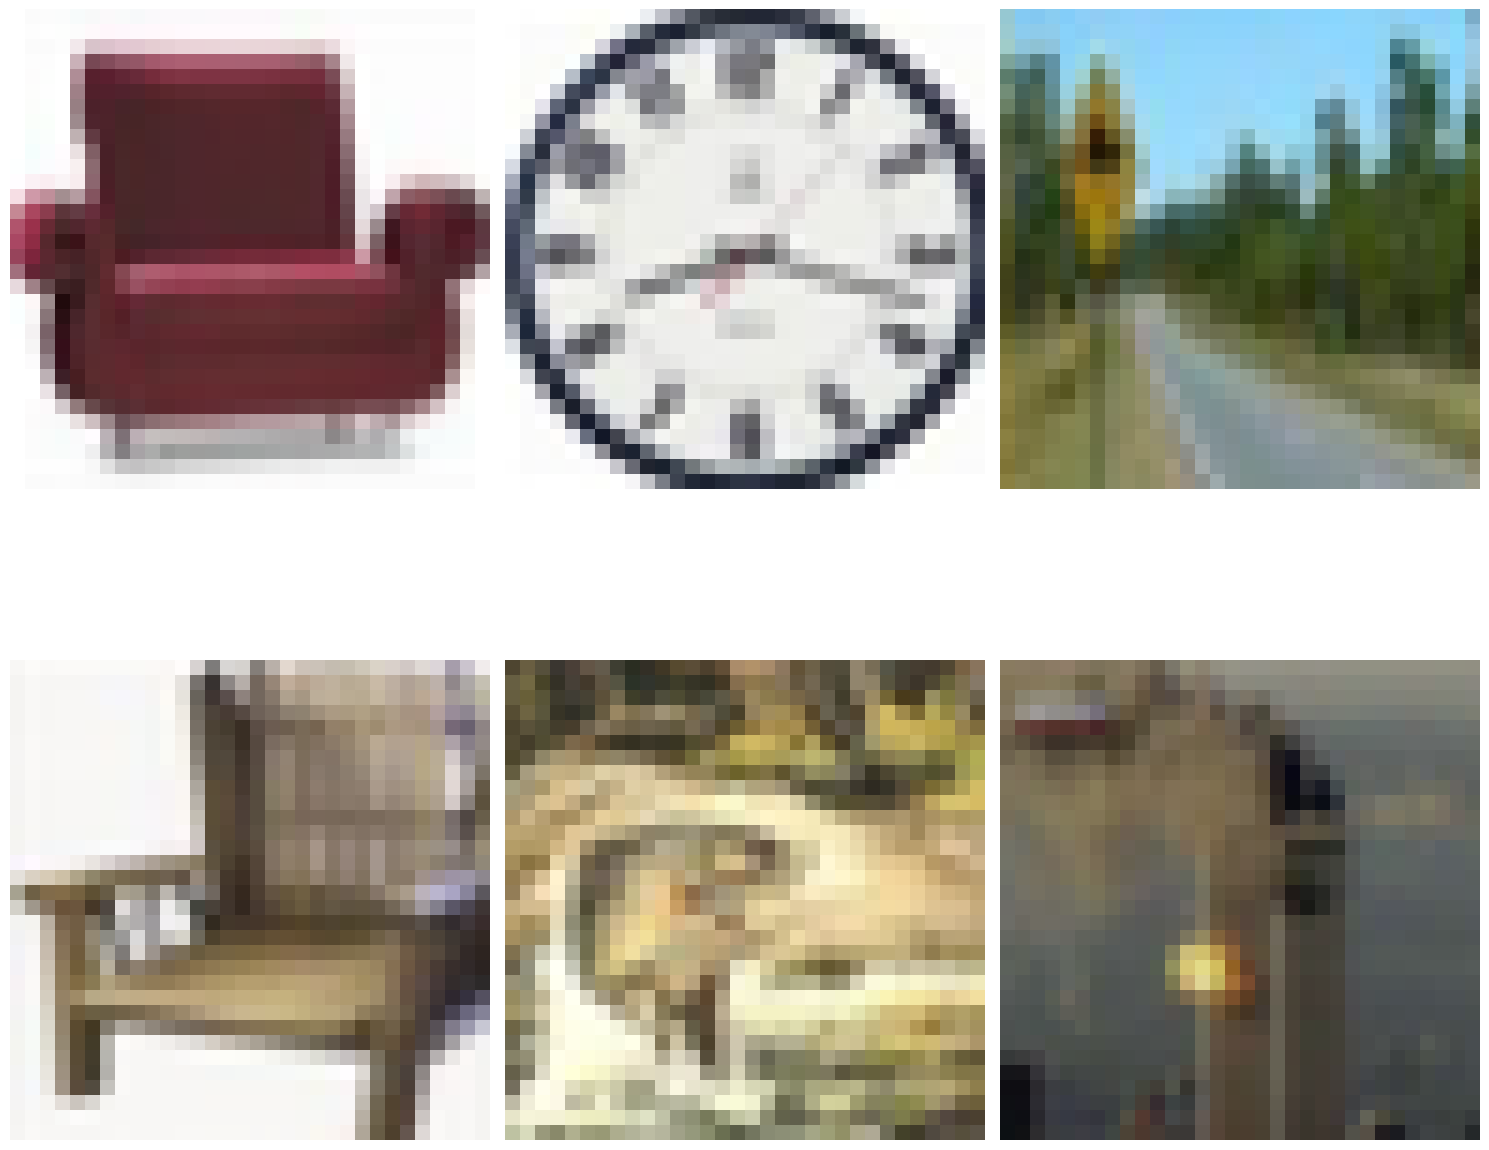

rotation


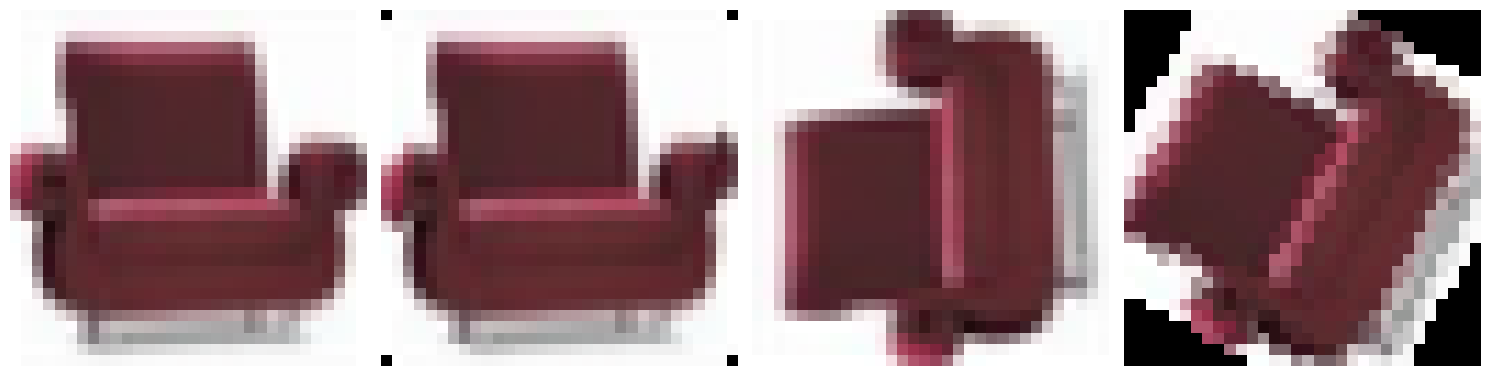

brightness


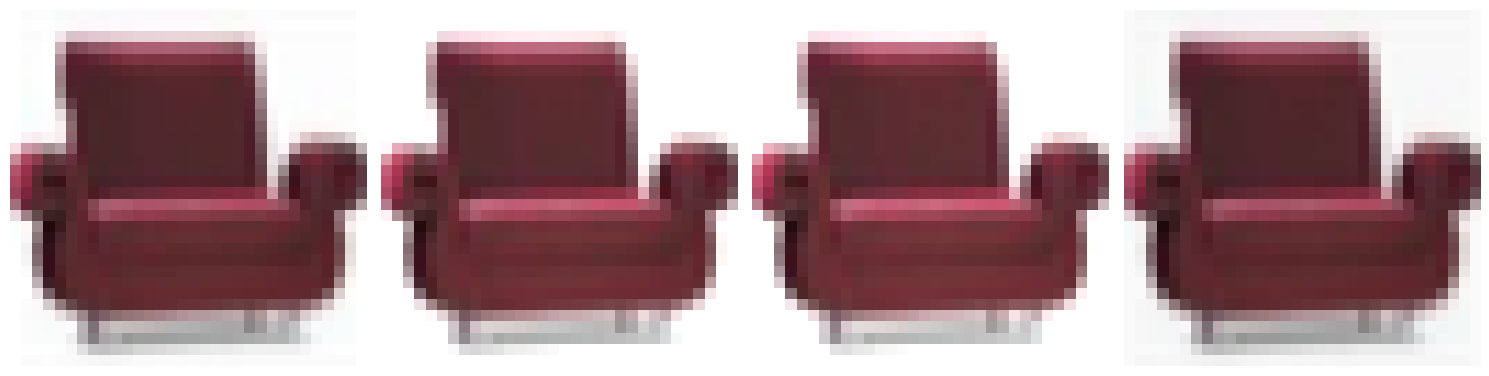

noise


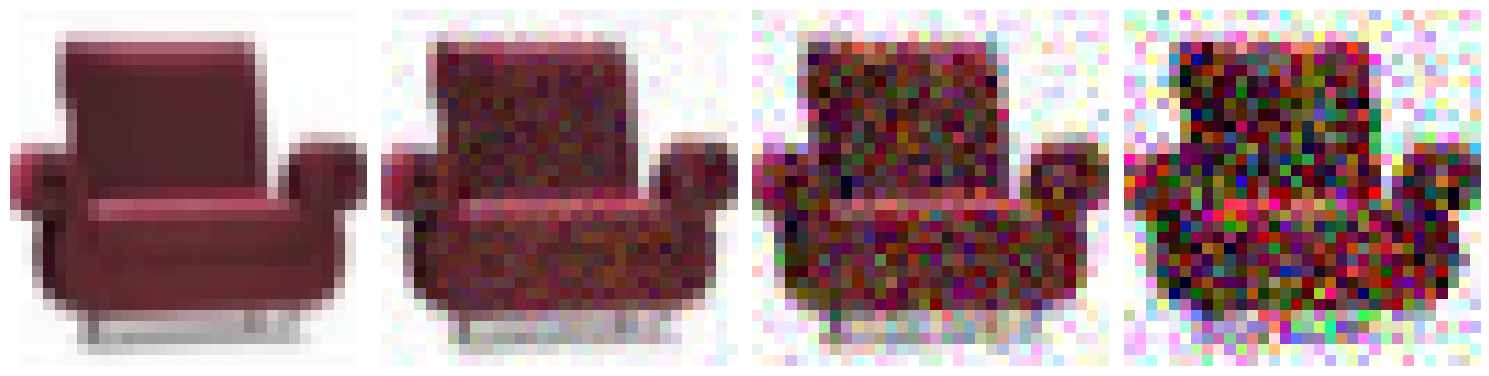

blur


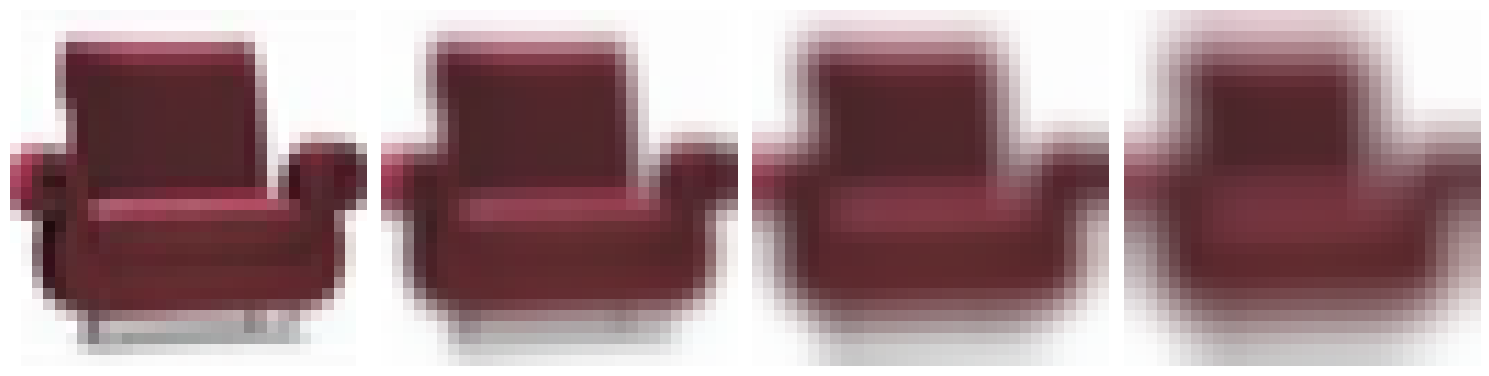

In [38]:
# Get 25 sample images
original_images = get_sample_images(25)

# Display original images
h,w = 2,3
display_image_grid(original_images[:h*w],h,w)

# Create transformed dataset
transformed_dataset = create_transformation_dataset(original_images)

# Display transformed images
for transformation_name, transformed_images in transformed_dataset.items():
    print(transformation_name)
    display_image_grid(transformed_images[:4],1,4)

### testing embedding functions

In [39]:
import warnings
import time # sometimes forget its already imported ?
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
num_examples = min(10,len(original_images))
def measure_embedding_times(image_list: Image.Image, embedding_functions: dict):
    results = {}
    for name, func in embedding_functions.items():
        #print("for funcation :", name)
        start_time = time.time()
        for image in image_list[:num_examples]:
            func(np.array(image))
            if time.time() - start_time > num_examples:
                break
        end_time = time.time()
        #print("the time is:", end_time - start_time)
        results[name] = end_time - start_time
    return results
embd_time = measure_embedding_times(original_images , embedding_functions )
for key ,value in embd_time.items():
    print("for funcation :", key,"the time is:"+str(round(value,5))+" seconds" if value < num_examples else "was over "+str(num_examples)+" seconds")

for funcation : simple_color_histogram_embedding the time is:0.004 seconds
for funcation : texture_embedding the time is:0.39736 seconds
for funcation : composition_rules_embedding the time is:0.001 seconds
for funcation : scene_complexity_embedding the time is:0.01001 seconds
for funcation : downsample_embedding the time is:0.0 seconds
for funcation : edge_histogram_embedding the time is:0.00901 seconds
for funcation : fft_embedding the time is:0.003 seconds
for funcation : sift_embedding the time is:0.01301 seconds
for funcation : cnn_embedding was over 10 seconds
for funcation : resnet18_embedding the time is:2.53532 seconds
for funcation : object_composition_embedding was over 10 seconds
for funcation : semantic_concept_embedding was over 10 seconds
for funcation : color_palette_embedding the time is:0.2232 seconds


C:\Users\nhpkm\miniconda3\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### Remove embedding functions labeled too slow

In [40]:
good_embedding_functions ={}
too_slow = [ key for key in embd_time.keys() if embd_time[key] > 0.03 ]
#print(too_slow)
# use results on my machine for stability
too_slow = [ 'cnn_embedding',
             'object_composition_embedding',
             'semantic_concept_embedding',
             'resnet18_embedding',
             'texture_embedding',
             'color_palette_embedding']
for key in embedding_functions:
    if key not in too_slow:
        good_embedding_functions[key] = embedding_functions[key]
    #good_embedding_functions.pop(key)

In [41]:
def compute_embedding_scores(embeddings):
    """
    Compute scores for transformed images based on their embedding distances

    Args:
    embeddings (torch.Tensor or np.ndarray): 100 image embeddings

    Returns:
    list: Scores for each set of 4 transformed images
    """
    # Ensure embeddings are numpy array
    if torch.is_tensor(embeddings):
        embeddings = embeddings.numpy()

    # Number of sets (25 original images * 4 transformation groups)
    num_sets = len(embeddings) // 4 # 25
    scores = []

    for set_idx in range(num_sets):
        # Select the base (original) image embedding
        base_index = set_idx * 4


        # Select the current set of 4 embeddings
        current_set_embeddings = embeddings[base_index:base_index+4]
        base_embedding = current_set_embeddings[0]

        # Compute distances between base embedding and all 100 embeddings
        distances = cdist([base_embedding], embeddings, metric='cosine')[0]

        # Compute ranks for each transformation
        ranks = []
        sorted_indices = np.argsort(distances)
        # Find the rank of the original images in this set
        for i in range(base_index,base_index+4):
            ranks.append(np.where(sorted_indices == i)[0][0])

        # Advanced scoring method
        # Exponential penalty for higher ranks with non-linear decay
        score = (
            4 * np.exp(-ranks[0]/10) +  # Original image
            3 * np.exp(-ranks[1]/20) +  # Lightly transformed
            2 * np.exp(-ranks[2]/30) +  # Moderately transformed
            1 * np.exp(-ranks[3]/50)    # Heavily transformed
        )

        scores.append(score)

    return scores


In [42]:
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

def comprehensive_embedding_analysis(
    image_transformations,
    embedding_functions,
    verbose=True
):
    """
    Analyze embedding performance across different transformation types and embedding methods

    Args:
    image_transformations (dict): {transform_name: [100 images]}
    embedding_functions (dict): {embedding_name: callable embedding function}
    verbose (bool): Whether to print detailed results

    Returns:
    dict: Comprehensive analysis results
    """
    # Final results storage
    analysis_results = {}

    # Iterate through each embedding method
    for embed_name, embed_func in embedding_functions.items():
        # Store results for this embedding method
        embed_results = {}

        # Iterate through each transformation type
        for transform_name, images in image_transformations.items():
            # Convert images to numpy array of embeddings
            try:
                embeddings = np.array([
                    embed_func(np.array(img)) for img in images
                ])
            except Exception as e:
                raise e
                print(f"Error embedding {transform_name} with {embed_name}: {e}")
                continue

            # Compute embedding scores
            try:
                scores = compute_embedding_scores(embeddings)

                # Compute statistics
                mean_score = np.mean(scores)
                std_score = np.std(scores)

                # Store results
                embed_results[transform_name] = {
                    #'scores': scores,
                    'mean_score': round( mean_score,5),
                    'std_score': round( std_score,5)
                }
            except Exception as e:
                raise e
                print(f"Error computing scores for {transform_name} with {embed_name}: {e}")

        # Store embedding method results
        analysis_results[embed_name] = embed_results

    # Verbose printing
    if verbose:
        print("\n===== Embedding Analysis Results =====")
        for embed_name, embed_results in analysis_results.items():
            print(f"\n{embed_name} Embedding Analysis:")
            for transform_name, result in embed_results.items():
                print(f"  {transform_name}:")
                print(f"    Mean Score: {result['mean_score']:.4f}")
                print(f"    Std Dev:    {result['std_score']:.4f}")

    return analysis_results

comprehensive_results = comprehensive_embedding_analysis(transformed_dataset, good_embedding_functions)


===== Embedding Analysis Results =====

simple_color_histogram_embedding Embedding Analysis:
  rotation:
    Mean Score: 9.3634
    Std Dev:    0.1611
  brightness:
    Mean Score: 8.1435
    Std Dev:    1.3176
  noise:
    Mean Score: 9.4713
    Std Dev:    0.1559
  blur:
    Mean Score: 9.6175
    Std Dev:    0.1429

composition_rules_embedding Embedding Analysis:
  rotation:
    Mean Score: 7.6658
    Std Dev:    0.6122
  brightness:
    Mean Score: 9.5879
    Std Dev:    0.0802
  noise:
    Mean Score: 9.4823
    Std Dev:    0.2926
  blur:
    Mean Score: 9.3242
    Std Dev:    0.6096

scene_complexity_embedding Embedding Analysis:
  rotation:
    Mean Score: 9.1204
    Std Dev:    0.3012
  brightness:
    Mean Score: 7.7329
    Std Dev:    1.2399
  noise:
    Mean Score: 8.6431
    Std Dev:    0.4505
  blur:
    Mean Score: 7.9472
    Std Dev:    1.2402

downsample_embedding Embedding Analysis:
  rotation:
    Mean Score: 8.2410
    Std Dev:    0.7113
  brightness:
    Mean Score

#### Remove embeddings that fail basic similarity test

In [43]:
low_score = [key for key in comprehensive_results if sum([comprehensive_results[key][k]["mean_score"] for k in comprehensive_results[key]]) <30]
# use results on my machine for stability
low_score = [ "fft_embedding"]
for key in low_score:
    good_embedding_functions.pop(key)



## Testing with larger Dataset image-net-200

C:\Users\nhpkm\AppData\Local\Temp\ipykernel_17644\2097511644.py:43: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = tf.keras.applications.MobileNetV2(


Loading dataset...


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Finding similar pairs...


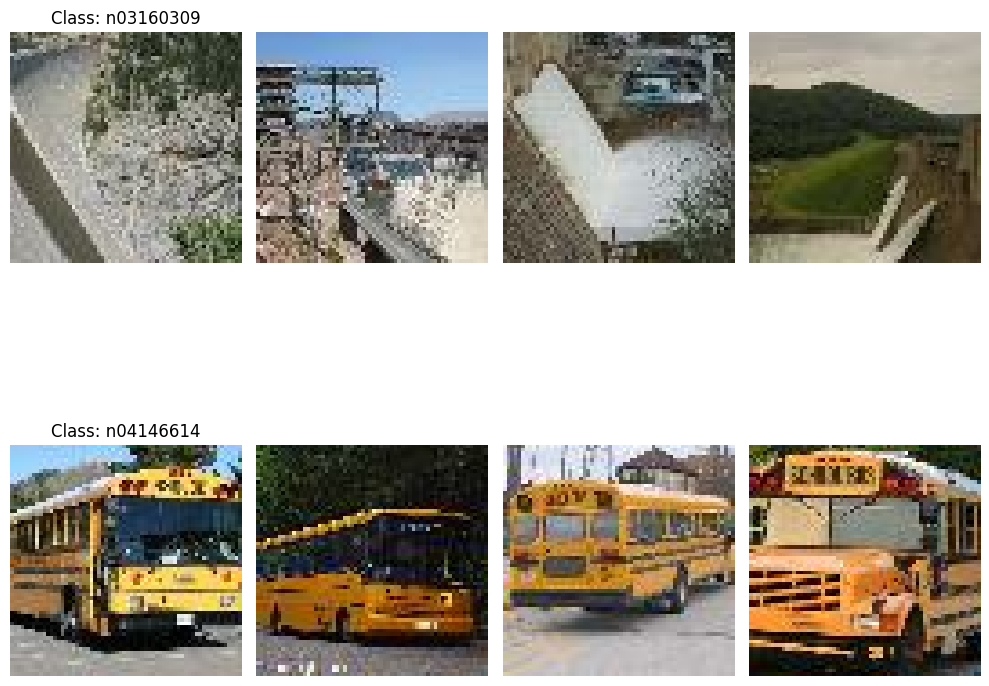

In [44]:
def download_tiny_imagenet(base_dir):
    """
    Downloads and extracts Tiny ImageNet dataset
    """
    os.makedirs(base_dir, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(base_dir, "tiny-imagenet-200.zip")

    if not os.path.exists(zip_path):
        print("Downloading Tiny ImageNet...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(zip_path, 'wb') as f:
            for data in tqdm(response.iter_content(chunk_size=1024), total=total_size // 1024):
                f.write(data)

    if not os.path.exists(os.path.join(base_dir, "tiny-imagenet-200")):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(base_dir)


def get_similar_image_pairs_tiny(num_pairs,pair_size = 2,  base_dir="./dataset", similarity_threshold=0.7, image_size=64):
    """
    Returns pairs of similar Tiny ImageNet images where pairs are from the same class,
    with additional similarity check for better matching.

    Args:
        num_pairs (int): Number of pairs to return
        base_dir (str): Directory to store/load dataset
        similarity_threshold (float): Minimum similarity for paired images
        image_size (int): Size to resize images to (Tiny ImageNet images are 64x64)

    Returns:
        numpy array: Selected images array of shape (num_pairs*2, image_size, image_size, 3)
        list: Class names for each pair
    """
    # Download and extract dataset if needed
    download_tiny_imagenet(base_dir)

    # Create feature extractor for similarity checks
    feature_extractor = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(image_size, image_size, 3),
        pooling='avg'
    )

    # Path to training images
    train_dir = os.path.join(base_dir, "tiny-imagenet-200", "train")

    # Dictionary to store images by class
    class_images = {}
    class_features = {}
    selected_images = []
    selected_class_names = []
    used_classes = set()

    def load_and_preprocess_image(image_path):
        """Load and preprocess image for feature extraction"""
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (image_size, image_size))
        img = tf.cast(img, tf.float32)
        return img, tf.keras.applications.mobilenet_v2.preprocess_input(img)

    # Load class data
    print("Loading dataset...")
    class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    class_dirs = random.sample(class_dirs, num_pairs)

    for class_dir in tqdm(class_dirs):
        class_path = os.path.join(train_dir, class_dir)
        image_files = [f for f in os.listdir(os.path.join(class_path, "images"))
                       if f.endswith('.JPEG')][:min(500 , 10+  pair_size) ]  # Take up to 10 images per class

        if len(image_files) >= pair_size:  # Only include classes with at least 2 images
            class_images[class_dir] = []
            class_features[class_dir] = []

            for img_file in image_files:
                img_path = os.path.join(class_path, "images", img_file)
                original_img, processed_img = load_and_preprocess_image(img_path)
                features = feature_extractor.predict(tf.expand_dims(processed_img, 0), verbose=0)

                class_images[class_dir].append(original_img)
                class_features[class_dir].append(features.flatten())

    print("Finding similar pairs...")
    """
    for _ in tqdm(range(num_pairs)):
        # Find an unused class
        available_classes = [c for c in class_images.keys()
                             if c not in used_classes and len(class_images[c]) >= pair_size]

        if not available_classes:
            raise ValueError(f"Not enough unique classes with sufficient images. "
                             f"Only found {len(selected_images) // pair_size} pairs.")

        # Pick a random unused class
        chosen_class = np.random.choice(available_classes)
        """
    for chosen_class in class_images.keys():
        if len(class_images[chosen_class]) <= pair_size:
            raise ValueError(f"Not enough unique classes with sufficient images. "
                             f"Only found {len(selected_images) // pair_size} pairs.")
        used_classes.add(chosen_class)

        # Get features for this class
        class_feat = class_features[chosen_class]
        class_imgs = class_images[chosen_class]

        # Pick first image randomly
        first_idx = np.random.randint(len(class_imgs))
        first_features = class_feat[first_idx]

        # Find most similar image
        similarities = [1 - cosine(first_features, feat) for feat in class_feat]
        similarities[first_idx] = -1  # Exclude the same image

        selected_class_names.append(chosen_class)
        selected_images.extend([class_imgs[first_idx].numpy()])
        #second_idx = np.argmax(similarities)
        pair_inxs = np.argpartition(similarities, pair_size - 1 )[ -(pair_size-1):]
        # Add the pair to our selection

        for second_idx in pair_inxs:
            selected_images.extend([ class_imgs[second_idx].numpy()])


    return np.array(selected_images), selected_class_names


def visualize_tiny_imagenet_pairs(images, class_names ,pair_size = 2  ):
    """
    Helper function to display the image pairs side by side with their class names

    Args:
        images (numpy array): Array of images to display
        class_names (list): List of class names for each pair
    """

    num_pairs = len(images) // pair_size
    fig, axes = plt.subplots(num_pairs, pair_size, figsize=(10, 5 * num_pairs))

    if num_pairs == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_pairs):
        for j in range(pair_size):
            idx = i * pair_size + j
            axes[i, j].imshow(images[idx].astype('uint8'))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'Class: {class_names[i]}')

    plt.tight_layout()
    plt.show()

# Get 3 pairs of similar images (6 images total)
images, class_names = get_similar_image_pairs_tiny(2 ,pair_size =4)

# Visualize the pairs with their class names
visualize_tiny_imagenet_pairs(images, class_names , pair_size =4 )

In [45]:
def display_images_with_labels_nparray(image1, image2, image3):
    # Create a figure and axis
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display images
    axes[0].imshow(image1.astype('uint8'))
    axes[0].set_title("Query image")
    axes[0].axis('off')
    
    axes[1].imshow(image2.astype('uint8'))
    axes[1].set_title("Agreed similar")
    axes[1].axis('off')
    
    axes[2].imshow(image3.astype('uint8'))
    axes[2].set_title("Proposed alternative similar")
    axes[2].axis('off')
    
    # Display the plot
    plt.show()

In [46]:
numer_of_images_per_class = 16 # todo make this very big
number_of_classes_from_tiny = 200

In [47]:
#start wrrapers that need class_ids
class_ids =[i for i in range(number_of_classes_from_tiny) for _ in range(numer_of_images_per_class) ]
methods_list["learn_class_weights"] = wrapper_learn_class_weights(class_ids)

In [48]:
pair_similar_images, class_names = get_similar_image_pairs_tiny(number_of_classes_from_tiny ,pair_size = numer_of_images_per_class)

C:\Users\nhpkm\AppData\Local\Temp\ipykernel_17644\2097511644.py:43: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = tf.keras.applications.MobileNetV2(


Loading dataset...


100%|██████████| 200/200 [06:55<00:00,  2.08s/it]


Finding similar pairs...


## applying embedding to large dataset

In [49]:
def get_all_embedings(image , embedding_functions = good_embedding_functions):
    return [ ef(image) for ef in embedding_functions.values()]

In [50]:
start_time = time.time()
pair_sample_embd = [  get_all_embedings(i) for i in pair_similar_images]
print( time.time() - start_time)

14.206424236297607


## Evaluating the ANN functions

In [51]:
import time
import numpy as np
from typing import Dict, Callable, Tuple, List
import pandas as pd
from IPython.display import clear_output




def evaluate_ann_search(
    embedded_images: List[np.ndarray],
    ann_methods: Dict[str, Callable],
    num_searches: int,
    pair_size: int = 2,
    K: int = 20,
    display = True
) -> pd.DataFrame:
    """
    Evaluates the performance of different ANN search functions on the provided embedded images.

    Args:
        embedded_images (List[np.ndarray]): List of embedded images, where each element is a
                                            numpy array representing the embeddings for one image.
        ann_methods (Dict[str, Callable]): Dictionary of ANN search functions, where the
                                           keys are the method names and the values are the
                                           search functions.
        num_searches (int): Number of searches to perform for each ANN method.
        pair_size (int, optional): Number of images per pair. Defaults to 2.
        K (int, optional): Number of nearest neighbors to retrieve. Defaults to 20.
        display (bool, optional): Whether to display additional information. Defaults to False.

    Returns:
        pd.DataFrame: Comprehensive performance metrics for each ANN search method
    """
    # Define comprehensive columns for performance metrics
    columns = [
        'Method Name',
        'Index Build Time',
        'Average Search Time',
        'Accuracy@K',
        'Recall@K',
        'Mean Average Precision@K',
        'Diversity Score'
    ]

    # Initialize results storage
    results = []

    # Ensure number of searches doesn't exceed available data
    num_searches = min(num_searches, len(embedded_images) // pair_size)

    # Randomly select search pairs
    pair_indices = np.random.choice(
        range(len(embedded_images) // pair_size),
        size=num_searches,
        replace=False
    ) * pair_size

    # Iterate through each ANN method
    for method_name, ANN_func in ann_methods.items():
        #print(f"Evaluating method: {method_name}")

        # Performance tracking variables
        search_times = []
        accuracies = []
        recalls = []
        map_scores = []
        diversity_scores = []

        # Index building time
        start_time = time.time()
        search_func = ANN_func(embedded_images)
        index_build_time = time.time() - start_time

        # Perform searches
        for indice in pair_indices:
            # Run the search
            start_time = time.time()
            distances, indices = search_func(embedded_images[indice], K)
            search_time = time.time() - start_time

            search_times.append(search_time)

            query_pairs = set([int(indice)+ i for i in range(1,pair_size )])
            set_inces = set(indices[:K].tolist()[0])
            matches = len(set_inces & query_pairs)

            # Calculate various metrics
            # Accuracy: Proportion of correct matches in top K results
            accuracies.append(matches / K )

            # Recall: Proportion of ground truth neighbors found
            recalls.append(matches / (pair_size -1))


            # Mean Average Precision
            precisions = []
            for i in range(1, K+1):
                precision_at_k = len(set(indices[:i].tolist()[0]) & query_pairs) / i
                precisions.append(precision_at_k)
            map_scores.append(np.mean(precisions))


            # Diversity Score: Measures the variety of retrieved results
            # Calculate variance of distances as a simple diversity metric
            diversity_scores.append(np.std(distances))

        # Compile method-level metrics
        method_results = {
            'Method Name': method_name,
            'Mean Average Precision@K': np.mean(map_scores),
            'Index Build Time': index_build_time,
            'Average Search Time': np.mean(search_times),
            'Accuracy@K': np.mean(accuracies),
            'Recall@K': np.mean(recalls),
            #'Diversity Score': np.mean(diversity_scores)
        }

        results.append(method_results)

    #clear_output(wait=False) # it messes with the future cells!?
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Optional display
    if display:
        print(results_df)

    return results_df

### Reverify embbeding quality over large dataset

In [52]:

# Type aliases for clarity
EmbeddingsList = List[List[np.ndarray]]  # List of lists of embeddings
SearchFunction = Callable[[List[np.ndarray]], Tuple[np.ndarray, np.ndarray]]

def limit_ann_functions_wrapper(function,data_indexs_list) -> SearchFunction:
    """
    call ANN funcation with subset of data
    """

    def indexing_stage(data: EmbeddingsList) -> SearchFunction:
        if not data or not all(data):
            raise ValueError("Data must be non-empty and all entries must have embeddings")

        if isinstance(data,np.ndarray):
            data = data[:data_indexs_list]
        else:
            data=[[row[ind] for ind in data_indexs_list] for row in data]


        resulting_search = function(data)

        def search(query_embeddings: List[np.ndarray], k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
            if isinstance(query_embeddings,np.ndarray):
                query_embeddings = query_embeddings[data_indexs_list]
            else:
                query_embeddings=[query_embeddings[ind] for ind in data_indexs_list]
            return resulting_search(query_embeddings,k)

        return search
    return  indexing_stage


In [53]:
compare_subset_methods = {}
simple_func = methods_list["hnsw_simple_concatenation"]
compare_subset_methods["concat all"] = simple_func
for i , name in enumerate(good_embedding_functions):
    compare_subset_methods["just_"+name]= limit_ann_functions_wrapper(simple_func,[i])
evaluate_ann_search(pair_sample_embd , compare_subset_methods , num_searches= 100 , pair_size= numer_of_images_per_class,K= 18 ,display= False )

,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,concat all,0.062135,0.061055,0.00008,0.017778,0.021333
1,just_simple_color_histogram_embedding,0.066019,0.024022,0.00005,0.018889,0.022667
2,just_composition_rules_embedding,0.023301,0.017015,0.00005,0.006667,0.008000
3,just_scene_complexity_embedding,0.034951,0.016015,0.00003,0.010000,0.012000
4,just_downsample_embedding,0.069902,0.027025,0.00007,0.020000,0.024000
5,just_edge_histogram_embedding,0.027184,0.025023,0.00006,0.007778,0.009333
6,just_sift_embedding,0.038835,0.030027,0.00007,0.011111,0.013333


## Results

In [58]:
evaluate_ann_search(pair_sample_embd , methods_list , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False )

during the training process of learn_class , found the weights for each embedding are [1.1328637431874984, 1.067860412853372, 1.2025952088604688, 0.7626234655718214, 0.9678448793407978, 0.8662122901860423]


,Method Name,Mean Average Precision@K,Index Build Time,Average Search Time,Accuracy@K,Recall@K
0,hnsw_simple_concatenation,0.048598,0.061055,0.000110,0.014375,0.015333
1,LSH_simple_concatenation,0.041203,0.060054,0.000165,0.012188,0.013000
2,separate indexing,0.055993,0.125113,0.004642,0.016563,0.017667
3,Split LSH,0.015847,0.076068,0.000415,0.004687,0.005000
4,just norm,0.050711,0.122111,0.006203,0.015000,0.016000
5,learn_class_weights,0.044372,0.735669,0.000110,0.013125,0.014000
6,Normalized and Scaled,0.058106,0.296269,0.000445,0.017188,0.018333
7,Dimension Reduction,0.048598,0.720654,0.000120,0.014375,0.015333
8,robust multi index,0.067615,0.134123,0.230948,0.020000,0.021333
9,Capped Distance,0.055993,0.030027,0.006526,0.016563,0.017667


## comapre to renet-18

In [55]:
print("remainder, the embedding functions used are ")
summ = 0
for name in good_embedding_functions.keys():
    print("for function :", name," with embedding time of:",round(embd_time[name],5),"seconds")
    summ+=embd_time[name]

print()
res_func ={"resnet18_embedding":resnet18_embedding}
resnet_restime = measure_embedding_times(original_images , res_func )
print("for resnet18 embedding time of:",round(list(resnet_restime.values())[0],5),"seconds")
print("all other functions had a total embedding time of:",round(summ,5),"seconds")

remainder, the embedding functions used are 
for function : simple_color_histogram_embedding  with embedding time of: 0.004 seconds
for function : composition_rules_embedding  with embedding time of: 0.001 seconds
for function : scene_complexity_embedding  with embedding time of: 0.01001 seconds
for function : downsample_embedding  with embedding time of: 0.0 seconds
for function : edge_histogram_embedding  with embedding time of: 0.00901 seconds
for function : sift_embedding  with embedding time of: 0.01301 seconds

for resnet18 embedding time of: 2.75453 seconds
all other functions had a total embedding time of: 0.03703 seconds


In [56]:
#limit_size = numer_of_images_per_class*100
embd_res = [  get_all_embedings(i,res_func) for i in pair_similar_images]#[:limit_size]]
embd_other = pair_sample_embd #[:limit_size]

In [57]:
print(evaluate_ann_search(embd_res , {"resnet-18":methods_list["hnsw_simple_concatenation"]} , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False ))
#todo change methods_list["hnsw_simple_concatenation"] to best methods
print(1)
print(evaluate_ann_search(embd_other , {"other embeddings concat ":methods_list["hnsw_simple_concatenation"],"using capped distance":methods_list["Capped Distance"]} , num_searches= 200 , pair_size= numer_of_images_per_class,K= numer_of_images_per_class ,display= False ))

  Method Name  Mean Average Precision@K  Index Build Time  \
0   resnet-18                  0.081349          0.055559   

   Average Search Time  Accuracy@K  Recall@K  
0              0.00011    0.024063  0.025667  
1
                Method Name  Mean Average Precision@K  Index Build Time  \
0  other embeddings concat                   0.048598          0.093085   
1     using capped distance                  0.055993          0.039035   

   Average Search Time  Accuracy@K  Recall@K  
0              0.00013    0.014375  0.015333  
1              0.00602    0.016563  0.017667  
